# Geometry without slope

In [1]:
import meep as mp
from meep import mpb

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [2]:
import sys
sys.path.append("/home/ben/Desktop/Thesis/github/Thesis_name/Simulations/")
from ExternalFunctions import (plot_unit_cell_cross_sections,
                              plot_epsilon_XY, hexagonal_lattice_bands_1)

In [ ]:
def geom_hexagon_glass_sub_PCS (params, cell):
    
    # Extraction of parameters. See PNAS paper.
    
    a, t, scaling = params
    
    sx = np.array(cell)[0]
    sy = np.array(cell)[1]
    sz = np.array(cell)[2]
    
    glass_t = 500 / a # 500 nm subtrate
    
    geometry = [mp.Block(center=mp.Vector3(0,0,0), size=mp.Vector3(mp.inf,mp.inf,t), material=mp.Medium(index = 1.9935))]
    geometry.append(mp.Block(center=mp.Vector3(0,0,-t/2-glass_t/2), size=mp.Vector3(mp.inf,mp.inf,glass_t), material=mp.Medium(index = 1.45)))

    # A hexagonal prism defined by six vertices centered on the origin
    # of material crystalline silicon (from the materials library)


    vertices = [mp.Vector3(scaling*2/np.sqrt(3),0),
                mp.Vector3(scaling*1/np.sqrt(3),scaling*1),
                mp.Vector3(-scaling*1/np.sqrt(3),scaling*1),
                mp.Vector3(scaling*-2/np.sqrt(3),0),
                mp.Vector3(-scaling*1/np.sqrt(3),-scaling*1),
                mp.Vector3(scaling*1/np.sqrt(3),-scaling*1)]

    vertices_new = []
    
    # we change the vertices to match the basis of our lattice

    geometry_lattice = mp.Lattice(size=mp.Vector3(1, 1, sz),
                              basis1=mp.Vector3(np.sqrt(3) / 2, 0.5, 0.0),
                              basis2=mp.Vector3(np.sqrt(3) / 2, -0.5, 0.0))
    vertices_new = []
    for vertice in vertices:
        vertices_new.append(mp.cartesian_to_lattice(vertice, geometry_lattice))

    geometry.append(mp.Prism(vertices_new, height=t, center=mp.Vector3(), material=mp.Medium(index = 1)))

    return geometry, geometry_lattice

In [3]:
resolution = 16
num_bands = 1

In [4]:
a = 405 # nm
t = 180 / a
scaling = (1-t)*0.5

In [5]:
sx = 1 
sy = 1 
sz = 10
cell = mp.Vector3(sx, sy, sz)

In [ ]:
parameters = [a, t, scaling]
geometry, geometry_lattice = geom_hexagon_glass_sub_PCS (parameters, cell)

In [ ]:
sim_params = resolution, cell, geometry
fig,  ax = plot_unit_cell_cross_sections(a, sim_params)

We see the glass substrate below the membrane.

In [ ]:
num_bands = 1
k_point = mp.Vector3(0.0,0.0,0.0)

sim_params = [geometry_lattice,  k_point, geometry, resolution, num_bands]

num_period = 3

xlim = [-520,520]
ylim = [-520,520]

title = 'XY cross section of 3 unit cells of the PCS'


fig, ax = plot_epsilon_XY (sim_params, a, num_period, xlim,  ylim, title, custom_material=False)

# Geometry with slope

In [ ]:
def geom_hexagon_PCS_glass_sub_slope (params):
    
    # Extraction of parameters
    
    dielec_const, a, t, alpha, geometry_lattice = params
    
    def  geometry(Vector3):
        
        array3 = np.array(mp.lattice_to_cartesian(Vector3, geometry_lattice))
        y = np.abs(array3 [0])
        x = np.abs(array3 [1])
        z = array3 [2]
    
    
        r1 = (1 - t)/ 2 #  upper radius (biggest one)
        r2 = r1 - t * np.sin(alpha)
            
        r = np.abs(0.5*(r1+r2)+ z*(r1-r2)/(t)) #this defines the slope of the walls
        h = r / np.sqrt(3) # r tan(30º)

    
        condition_x_square = np.abs(x) <= r
        condition_y_square = np.abs(y) <= h
    
        condition_x_triangle = np.abs(x) <= r
        condition_y_triangle = h <= np.abs(y) <= -h/r * np.abs(x) + 2*h
            
        condition_z = np.abs(z) <= t*0.5
    
    
        if condition_x_square and condition_y_square and condition_z:
        
            eps = mp.Medium(index = 1) 

        
        elif condition_x_triangle and condition_y_triangle and condition_z:
        
            eps = mp.Medium(index = 1)  
            
        elif  condition_z:
            
            eps = mp.Medium(index = dielec_const)

        else:
        
            eps = mp.Medium(index = 1) 
        
        if -500/a - t/2 < z < -t /2:
         
            eps = mp.Medium(index = 1.45) 
        
        return eps

    return geometry


In [ ]:
custom_material = True

dielec_const = 1.9935
alpha = 7.9 * np.pi / 180
params = dielec_const, a, t, alpha, geometry_lattice

eps_func = geom_hexagon_PCS_glass_sub_slope(params)
default_material = eps_func

In [ ]:
sim_params = resolution, cell, default_material

fig, ax = plot_unit_cell_cross_sections(a, sim_params, custom_material = True)

In [ ]:
num_bands = 1
k_point = mp.Vector3(0.0,0.0,0.0)

sim_params = [geometry_lattice,  k_point, default_material, resolution, num_bands]

num_period = 3

xlim = [-520,520]
ylim = [-520,520]

title = 'XY cross section of 3 unit cells of the PCS'


fig, ax = plot_epsilon_XY (sim_params, a, num_period, xlim,  ylim, title, custom_material=True)

# Band calculation

In [6]:
import os
path = os.path.abspath(os.getcwd())
print(path)

/home/ben/Desktop/Thesis/github/Thesis_name/Simulations/04_Photonic_Crystal_Slabs/Hexagonal_Hole_Hexagonal_Lattice


In [7]:
f1 = np.genfromtxt(path+"/data/glass_substrate_bands.dat", delimiter=",")[1:,1:]
f2 = np.genfromtxt(path+"/data/glass_substrate_bands_TE.dat", delimiter=",")[1:,1:]
f3 = np.genfromtxt(path+"/data/glass_substrate_bands_TM.dat", delimiter=",")[1:,1:]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


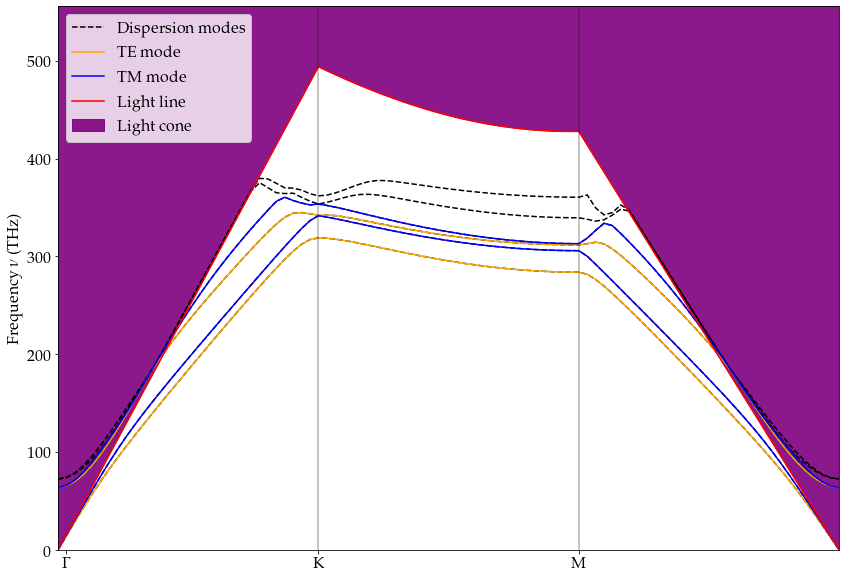

In [8]:
files = [f1,f2,f3]

fig, ax = hexagonal_lattice_bands_1(a* 1e-9, files) #because in nanometers

In [ ]:
if save == True:
    fig.savefig('results/band_diagram_glass_substrate.pdf')

In [9]:
f4 = np.genfromtxt(path+"/data/glass_substrate_bands_slope.dat", delimiter=",")[1:-1,1:]

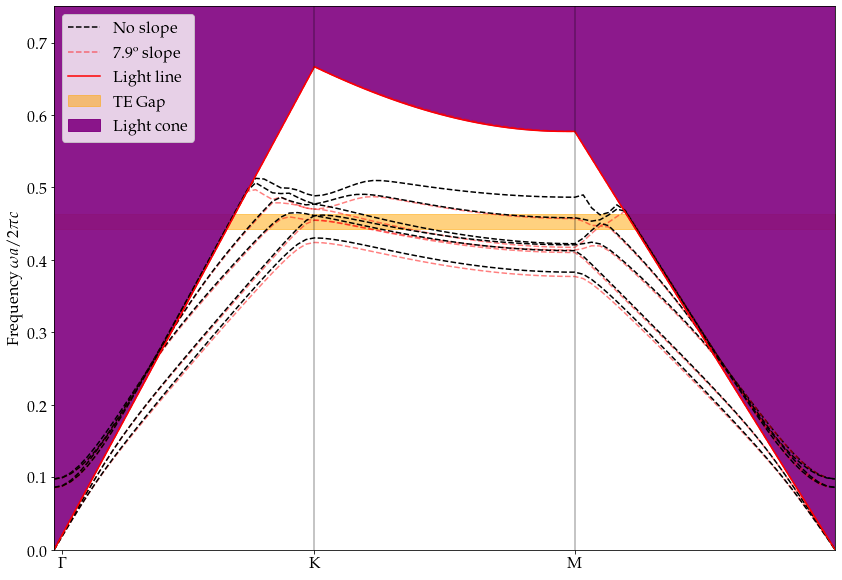

In [10]:
fig, ax = plt.subplots(figsize=(14,10))

for i in range(1,7):
    
    if i == 1:
        ax.plot(np.linspace(0,len(f1[:,1])-1, len(f1[:,1])), f1[:,-i], c='black', linestyle='dashed', label = 'No  slope')
        ax.plot(np.linspace(0,len(f4[:,1])-1, len(f4[:,1])), f4[:,-i], c='red', linestyle='dashed', alpha=0.5, label = '7.9º  slope') 

    else:
        ax.plot(np.linspace(0,len(f1[:,1])-1, len(f1[:,1])), f1[:,-i], c='black', linestyle='dashed')
        if i > 6:
            continue
        ax.plot(np.linspace(0,len(f4[:,1])-1, len(f4[:,1])), f4[:,-i], c='red', alpha=0.5, linestyle='dashed') 


K_index = int(0.33*len(f1[:,1])) 
M_index = int(0.66*len(f1[:,1])) 
k_point = np.linspace(0,len(f1[:,1])-1, len(f1[:,1]))

k_till_K = np.array([np.linspace(0, 1/np.sqrt(3), K_index +1), np.linspace(0, 1/3,  K_index+1)])
k_till_M = np.array([1/np.sqrt(3)*np.ones(M_index - K_index ), np.linspace(1/3, 0,  M_index - K_index )])
k_till_Gamma = np.array([np.linspace(1/np.sqrt(3), 0, len(f1[:,1]) - M_index), np.zeros(len(f1[:,1]) - M_index)])

ax.fill_between(k_point, np.max(f2[:,-2])*np.ones_like(k_point), np.min(f2[K_index:M_index,-1])*np.ones_like(k_point), color='orange', alpha=0.5, label='TE Gap') 
ks = np.hstack([k_till_K,k_till_M[:,1:],k_till_Gamma])
Light_line = np.sqrt(ks[0,:]**2 + ks[1,:]**2)


ax.plot(k_point,  np.array(Light_line), c='r', label ='Light line')
ax.fill_between(k_point, Light_line, np.ones_like(k_point), color='purple', alpha=0.9, label='Light cone')


plt.axvline(x= K_index, c='black', alpha=0.3)
plt.axvline(x= M_index, c='black', alpha=0.3)


ax.set_xticks([1,  K_index, M_index, len(f1[:,1])])
ax.set_xticklabels(['$\\Gamma$', 'K', 'M','$\\Gamma$'])
ax.set_xlim([0,len(f1[:,1])-1])
ax.set_ylim([0,0.75])
ax.set_xlabel("")
ax.set_ylabel("Frequency $\omega a / 2 \pi c$")
ax.legend(loc=2)